## Evaluate a custom Presidio Analyzer using the Presidio Evaluator framework

This notebook demonstrates how to evaluate a Presidio instance using the presidio-evaluator framework. It builds upon [example 4](4_Evaluate_Presidio_Analyzer.ipynb), with changes to the `PresidioAnalyzer` instance to improve detection accuracy. For more information on customizing the Presidio Analyzer, see the [Presidio Analyzer documentation](https://microsoft.github.io/presidio/analyzer/) or this [tutorial](https://microsoft.github.io/presidio/tutorial/).

Steps:
1. Load dataset from file
2. Simple dataset statistics
3. Define the AnalyzerEngine object (and its parameters)
4. Align the dataset's entities to Presidio's entities
5. Set up the Evaluator object
6. Run experiment
7. Evaluate results
8. Error analysis

In [1]:
# install presidio evaluator via pip if not yet installed

#!pip install presidio-evaluator
#!pip install "presidio-analyzer[transformers]"

In [2]:
from pathlib import Path
from copy import deepcopy
from pprint import pprint
from collections import Counter
from typing import Dict, List
import json
import warnings
warnings.filterwarnings('ignore')

from presidio_evaluator import InputSample
from presidio_evaluator.evaluation import Evaluator, ModelError, Plotter
from presidio_evaluator.models import PresidioAnalyzerWrapper
from presidio_evaluator.experiment_tracking import get_experiment_tracker

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## 1. Load dataset from file

In [3]:
dataset_name = "synth_dataset_v2.json"
dataset = InputSample.read_dataset_json(Path(Path.cwd().parent, "data", dataset_name))

print(len(dataset))

tokenizing input:   0%|          | 0/1500 [00:00<?, ?it/s]

loading model en_core_web_sm


tokenizing input: 100%|██████████| 1500/1500 [00:07<00:00, 213.50it/s]

1500


This dataset was auto generated. See more info here [Synthetic data generation](1_Generate_data.ipynb).

In [4]:
def get_entity_counts(dataset: List[InputSample]) -> Dict:
    """Return a dictionary with counter per entity type."""
    entity_counter = Counter()
    for sample in dataset:
        for tag in sample.tags:
            entity_counter[tag] += 1
    return entity_counter


## 2. Simple dataset statistics

In [5]:
entity_counts = get_entity_counts(dataset)
print("Count per entity:")
pprint(entity_counts.most_common(), compact=True)

print("\nMin and max number of tokens in dataset: "\
f"Min: {min([len(sample.tokens) for sample in dataset])}, "\
f"Max: {max([len(sample.tokens) for sample in dataset])}")

print(f"Min and max sentence length in dataset: " \
f"Min: {min([len(sample.full_text) for sample in dataset])}, "\
f"Max: {max([len(sample.full_text) for sample in dataset])}")

Count per entity:
[('O', 19626), ('STREET_ADDRESS', 3071), ('PERSON', 1369), ('GPE', 521),
 ('ORGANIZATION', 504), ('PHONE_NUMBER', 350), ('DATE_TIME', 219),
 ('TITLE', 142), ('CREDIT_CARD', 136), ('US_SSN', 80), ('AGE', 74), ('NRP', 55),
 ('ZIP_CODE', 50), ('EMAIL_ADDRESS', 49), ('DOMAIN_NAME', 37),
 ('IP_ADDRESS', 22), ('IBAN_CODE', 21), ('US_DRIVER_LICENSE', 9)]

Min and max number of tokens in dataset: Min: 3, Max: 78
Min and max sentence length in dataset: Min: 9, Max: 407


## 3. Define the AnalyzerEngine object 
In this case, we customize the AnalyzerEngine to use a different NER model, some custom recognizers and the context aware enhancer.

### 3.1 Set up the NlpEngine
The NLP engine is in charge of text processing using spaCy, and named entity recognition using a transformers model

In [6]:
from presidio_analyzer.nlp_engine import TransformersNlpEngine, NerModelConfiguration

# Define which model to use
model_config = [{"lang_code": "en", "model_name": {
    "spacy": "en_core_web_sm",  # use a small spaCy model for lemmas, tokens etc.
    "transformers": "StanfordAIMI/stanford-deidentifier-base"
    }
}]

# Map transformers model labels to Presidio's
model_to_presidio_entity_mapping = dict(
    PER="PERSON",
    PERSON="PERSON",
    LOC= "LOCATION",
    LOCATION= "LOCATION",
    GPE="LOCATION",
    ORG="ORGANIZATION",
    ORGANIZATION="ORGANIZATION",
    NORP="NRP",
    AGE="AGE",
    ID="ID",
    EMAIL="EMAIL",
    PATIENT="PERSON",
    STAFF="PERSON",
    HOSP="ORGANIZATION",
    PATORG="ORGANIZATION",
    DATE="DATE_TIME",
    TIME="DATE_TIME",
    PHONE="PHONE_NUMBER",
    HCW="PERSON",
    HOSPITAL="ORGANIZATION",
    FACILITY="LOCATION",
    VENDOR="ORGANIZATION",
    
)

ner_model_configuration = NerModelConfiguration(labels_to_ignore = ["O"], 
                                                model_to_presidio_entity_mapping=model_to_presidio_entity_mapping)

nlp_engine = TransformersNlpEngine(models=model_config,
                                   ner_model_configuration=ner_model_configuration)
nlp_engine.load()

### 3.2 Set up the relevant recognizers
Add and remove recognizers to fit the dataset in hand. 
Adding simple titles and zip code recognizers, another deny list for things that aren't considered PII but labeled as such,
and removing all the recognizers that don't map to entities in our dataset.

In [39]:
from presidio_analyzer import AnalyzerEngine, PatternRecognizer, RecognizerRegistry, Pattern

# Add a simple deny-list recognizer for titles
def get_titles_recognizer():
    titles_recognizer = PatternRecognizer(deny_list=["Mr.", "Mrs.", "Ms.", "Miss", "Dr.", "Prof.", "manager"],
                                          supported_entity="TITLE", name="TitlesRecognizer")
    return titles_recognizer

def get_location_deny_list():
    location_deny_list = PatternRecognizer(deny_list=["APO", "PSC", "AA", "Cyprus (Greek)", 
                                                      "ul", "AE", "DPO", "AP", "nan"],
                                          supported_entity="LOCATION", name="LocationDenylist")
    return location_deny_list

# Add a simple regex to identify ages
def get_age_recognizer():
    weak_regex= r"\b(110|[1-9]?[0-9])\b"
    age_pattern = Pattern(name="age (very weak)", 
                          regex=weak_regex, 
                          score=0.01)
    age_recognizer = PatternRecognizer(
        supported_entity="AGE",
        patterns = [age_pattern],
        name="AgeRecognizer",
        context=["month", "old", "turn", "age", "y/o"]
    )
    return age_recognizer


# Add a simple regex recognizer for zip codes
def get_zipcode_recognizer():
    weak_regex = r"\b\d{3,5}(?:-\d{3})?\b"
    med_regex = r"""
    (?:                           # Non-capturing group for matching
        (?:zip(?:code)?.{0,10})|  # Matches 'zip' or 'zipcode' with up to 10 non-alphanumeric characters
        (?:[A-Z]{2}\s)            # Matches a two-letter state acronym followed by a space
    )                             # End of non-capturing group
    (\d{3,7}(?:-\d{3})?)          # Captures 3 to 7 digits for the zip code, optionally followed by a dash and 3 more digits
    """ # weak regex pattern
    zipcode_pattern_weak = Pattern(name="zip code (weak)", regex=weak_regex, score=0.01)
    zipcode_pattern_med = Pattern(name="zip code (medium)", regex=med_regex, score=0.4)


    # Define the recognizer with the defined pattern
    zipcode_recognizer = PatternRecognizer(
        supported_entity="ZIP_CODE", 
        patterns=[zipcode_pattern_weak, zipcode_pattern_med], 
        name="ZipCodeRecognizer", 
        context=["zip", "zipcode"]
    )
    return zipcode_recognizer

# Add it to the Recognizer Registry
registry = RecognizerRegistry()
registry.load_predefined_recognizers(nlp_engine=nlp_engine)
registry.add_recognizer(get_titles_recognizer())
registry.add_recognizer(get_zipcode_recognizer())
registry.add_recognizer(get_location_deny_list())
registry.add_recognizer(get_age_recognizer())

# Remove unnecessary recognizers from presidio
unnecessary = ['NhsRecognizer', 'UkNinoRecognizer', 'SgFinRecognizer', 'AuAbnRecognizer', 
               'AuAcnRecognizer','AuTfnRecognizer', 'AuMedicareRecognizer', 'InPanRecognizer',
               'InAadhaarRecognizer', 'InVehicleRegistrationRecognizer', 'InPassportRecognizer', 
               'InVoterRecognizer']

[registry.remove_recognizer(rec) for rec in unnecessary]


[None, None, None, None, None, None, None, None, None, None, None, None]

### 3.3 Configure the context mechanism
Configure the `LemmaContextAawareEnhancer` which uses surrounding words to increase confidence in detection

In [40]:
from presidio_analyzer.context_aware_enhancers import LemmaContextAwareEnhancer

# Set up the context aware enhancer
context_enhancer = LemmaContextAwareEnhancer(context_prefix_count=10, 
                                             context_suffix_count=10)

### 3.4 Create the AnalyzerEngine object

In [25]:
# Set up the engine, loads the NLP module (spaCy model by default) 
# and other PII recognizers
analyzer_engine = AnalyzerEngine(nlp_engine=nlp_engine, 
                                 context_aware_enhancer=context_enhancer,
                                 registry=registry, 
                                 default_score_threshold=0.3)

pprint(f"Supported entities for English:")
pprint(analyzer_engine.get_supported_entities("en"), compact=True)

print(f"\nLoaded recognizers for English:")
pprint([rec.name for rec in analyzer_engine.registry.get_recognizers("en", all_fields=True)], compact=True)

print(f"\nLoaded Context Aware Enhancer:")
print(analyzer_engine.context_aware_enhancer.__class__.__name__)
pprint(json.dumps(analyzer_engine.context_aware_enhancer.__dict__), compact=True)


print(f"\nLoaded NER models:")
pprint(analyzer_engine.nlp_engine.models)

'Supported entities for English:'
['MEDICAL_LICENSE', 'US_DRIVER_LICENSE', 'URL', 'CREDIT_CARD', 'ZIP_CODE',
 'TITLE', 'CRYPTO', 'DATE_TIME', 'ID', 'EMAIL_ADDRESS', 'US_BANK_NUMBER', 'NRP',
 'PHONE_NUMBER', 'PERSON', 'EMAIL', 'US_PASSPORT', 'US_SSN', 'IP_ADDRESS',
 'ORGANIZATION', 'LOCATION', 'US_ITIN', 'IBAN_CODE', 'AGE']

Loaded recognizers for English:
['CreditCardRecognizer', 'UsBankRecognizer', 'UsLicenseRecognizer',
 'UsItinRecognizer', 'UsPassportRecognizer', 'UsSsnRecognizer',
 'CryptoRecognizer', 'DateRecognizer', 'EmailRecognizer', 'IbanRecognizer',
 'IpRecognizer', 'MedicalLicenseRecognizer', 'PhoneRecognizer', 'UrlRecognizer',
 'TransformersRecognizer', 'TitlesRecognizer', 'ZipCodeRecognizer',
 'LocationDenylist', 'AgeRecognizer']

Loaded Context Aware Enhancer:
LemmaContextAwareEnhancer
('{"context_similarity_factor": 0.35, "min_score_with_context_similarity": '
 '0.4, "context_prefix_count": 10, "context_suffix_count": 10}')

Loaded NER models:
[{'lang_code': 'en',
  'mod

In [41]:
# Test Analyzer
text="Yesterday in Mt. Sinai AP: Dana Silver, 79 years old female was complaining of stomach pain. Her ID is 154555"
res = analyzer_engine.analyze(text=text, 
                              language="en", 
                              return_decision_process=True)
for result in res:
    print(f"\nEntity: {result.entity_type}, Text: {text[result.start:result.end]}\n\nAnalysis explanation:")
    pprint(result.analysis_explanation)


Entity: LOCATION, Text: AP

Analysis explanation:
{'recognizer': 'LocationDenylist', 'pattern_name': 'deny_list', 'pattern': '(?:^|(?<=\\W))(APO|PSC|AA|Cyprus\\ \\(Greek\\)|ul|AE|DPO|AP|nan)(?:(?=\\W)|$)', 'original_score': 1.0, 'score': 1.0, 'textual_explanation': 'Detected by `LocationDenylist` using pattern `deny_list`', 'score_context_improvement': 0, 'supportive_context_word': '', 'validation_result': None, 'regex_flags': regex.I|regex.M|regex.S}

Entity: ID, Text: 154555

Analysis explanation:
{'recognizer': 'TransformersRecognizer', 'pattern_name': None, 'pattern': None, 'original_score': 0.99888223, 'score': 0.99888223, 'textual_explanation': "Identified as ID by Transformers's Named Entity Recognition", 'score_context_improvement': 0, 'supportive_context_word': '', 'validation_result': None, 'regex_flags': None}

Entity: ORGANIZATION, Text: Mt. Sinai

Analysis explanation:
{'recognizer': 'TransformersRecognizer', 'pattern_name': None, 'pattern': None, 'original_score': 0.9806

## 4. Align the dataset's entities to Presidio's entities

There is possibly a difference between the names of entities in the dataset, and the names of entities Presidio can detect.
For example, it could be that a dataset labels a name as PER while Presidio returns PERSON. To be able to compare the predicted value to the actual and gather metrics, an alignment between the entity names is necessary. Consider changing the mapping if your dataset and/or Presidio instance supports difference entity types.

In [42]:
entities_mapping=PresidioAnalyzerWrapper.presidio_entities_map # default mapping
# Add titles and zip codes as we have recognizers for those
entities_mapping["TITLE"] = "TITLE"
entities_mapping["PREFIX"] = "TITLE"
entities_mapping["ZIP_CODE"] = "LOCATION" # To avoid conflating zip codes with addresses
entities_mapping["NRP"] = "ORGANIZATION" # We don't have a NRP recognizer with this setup


print("Entities mapping:")
pprint(entities_mapping)

dataset = Evaluator.align_entity_types(
    dataset, 
    entities_mapping=entities_mapping, 
    allow_missing_mappings=True
)
new_entity_counts = get_entity_counts(dataset)
print("\nCount per entity after alignment:")
pprint(new_entity_counts.most_common(), compact=True)

dataset_entities = list(new_entity_counts.keys())

Entities mapping:
{'ADDRESS': 'LOCATION',
 'AGE': 'AGE',
 'BIRTHDAY': 'DATE_TIME',
 'CITY': 'LOCATION',
 'CREDIT_CARD': 'CREDIT_CARD',
 'DATE': 'DATE_TIME',
 'DATE_OF_BIRTH': 'DATE_TIME',
 'DATE_TIME': 'DATE_TIME',
 'DOB': 'DATE_TIME',
 'DOMAIN': 'URL',
 'DOMAIN_NAME': 'URL',
 'EMAIL': 'EMAIL_ADDRESS',
 'EMAIL_ADDRESS': 'EMAIL_ADDRESS',
 'FACILITY': 'LOCATION',
 'FIRST_NAME': 'PERSON',
 'GPE': 'LOCATION',
 'HCW': 'PERSON',
 'HOSP': 'ORGANIZATION',
 'HOSPITAL': 'ORGANIZATION',
 'IBAN': 'IBAN_CODE',
 'IBAN_CODE': 'IBAN_CODE',
 'ID': 'ID',
 'IP_ADDRESS': 'IP_ADDRESS',
 'LAST_NAME': 'PERSON',
 'LOC': 'LOCATION',
 'LOCATION': 'LOCATION',
 'NATIONALITY': 'NRP',
 'NORP': 'NRP',
 'NRP': 'ORGANIZATION',
 'O': 'O',
 'ORG': 'ORGANIZATION',
 'ORGANIZATION': 'ORGANIZATION',
 'PATIENT': 'PERSON',
 'PATORG': 'ORGANIZATION',
 'PER': 'PERSON',
 'PERSON': 'PERSON',
 'PHONE': 'PHONE_NUMBER',
 'PHONE_NUMBER': 'PHONE_NUMBER',
 'PREFIX': 'TITLE',
 'SSN': 'US_SSN',
 'STAFF': 'PERSON',
 'STREET_ADDRESS': 'LOC

## 5. Set up the Evaluator object

In [43]:
# Set up the experiment tracker to log the experiment for reproducibility
experiment = get_experiment_tracker()
 
# Create a wrapper for Presidio to be used within the presidio-evaluator framework
model = PresidioAnalyzerWrapper(analyzer_engine)

# Create the evaluator object
evaluator = Evaluator(model=model)


# Track model and dataset params
params = {"dataset_name": dataset_name, "model_name": model.name}
params.update(model.to_log())
experiment.log_parameters(params)
experiment.log_dataset_hash(dataset)
experiment.log_parameter("entity_mappings", json.dumps(entities_mapping))

--------
Entities supported by this Presidio Analyzer instance:
MEDICAL_LICENSE, US_DRIVER_LICENSE, URL, CREDIT_CARD, ZIP_CODE, TITLE, CRYPTO, DATE_TIME, ID, EMAIL_ADDRESS, US_BANK_NUMBER, NRP, PHONE_NUMBER, PERSON, EMAIL, US_PASSPORT, US_SSN, IP_ADDRESS, ORGANIZATION, LOCATION, US_ITIN, IBAN_CODE, AGE


## 6. Run experiment

In [44]:
%%time

## Run experiment

evaluation_results = evaluator.evaluate_all(dataset)
results = evaluator.calculate_score(evaluation_results)

# Track experiment results
experiment.log_metrics(results.to_log())
entities, confmatrix = results.to_confusion_matrix()
experiment.log_confusion_matrix(matrix=confmatrix, 
                                labels=entities)

# end experiment
experiment.end()

# Note that the experiment params and metrics are saved locally

Running model PresidioAnalyzerWrapper on dataset...
Finished running model on dataset
saving experiment data to experiment_20241122-001013.json
CPU times: user 3min 5s, sys: 27.6 s, total: 3min 33s
Wall time: 57.3 s


## 7. Evaluate results

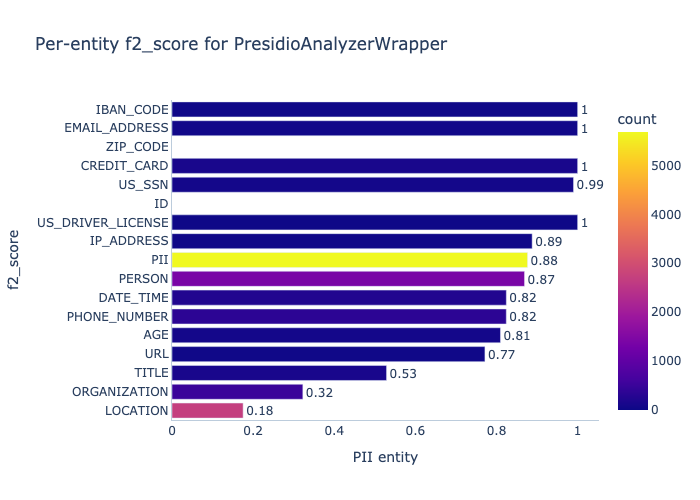

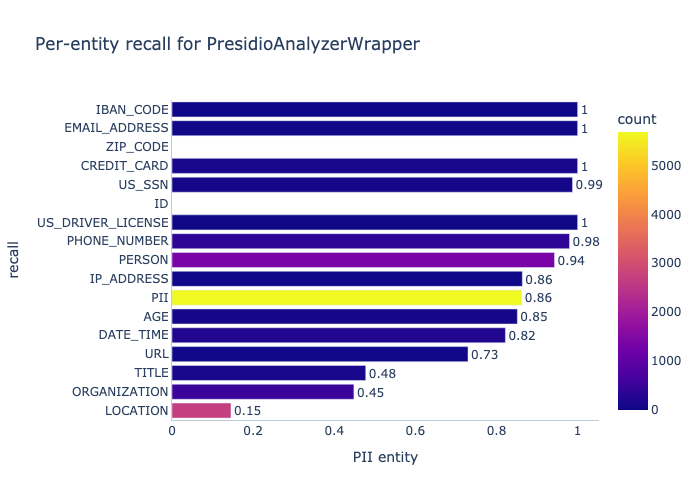

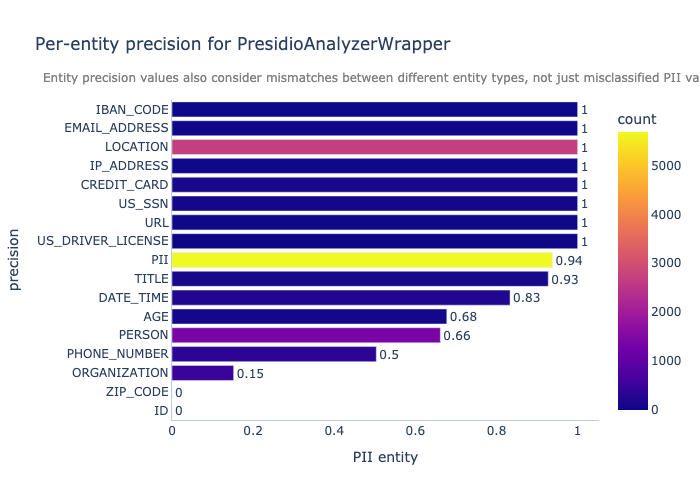

In [ ]:
# Plot output
plotter = Plotter(results=results, 
                  model_name = model.name, 
                  #save_as="png",
                  beta = 2)

plotter.plot_scores()

In [57]:
pprint({"PII F":results.pii_f, "PII recall": results.pii_recall, "PII precision": results.pii_precision})

{'PII F': 0.8765153953438473,
 'PII precision': 0.9378228429309355,
 'PII recall': 0.8624208304011259}


## 8. Error analysis

Now let's look into results to understand what's behind the metrics we're getting.
Note that evaluation is never perfect. Some things to consider:

1. There's often a mismatch between the annotated span and the predicted span, which isn't necessarily a mistake. For example: `<Southern France>` compared with `Southern <France>`. In the second text, the word `Southern` was not annotated/predicted as part of the entity, but that's not necessarily an error.
2. Token based evaluation (which is used here) counts the number of true positive / false positive / false negative tokens. Some entities might be broken into more tokens than others. For example, the phone number `222-444-1234` could be broken into five different tokens, whereas `Krishna` would be broken into one token, resulting in phone numbers having more influence on metrics than names.
3. The synthetic dataset used here isn't representative of a real dataset. Consider using more realistic datasets for evaluation

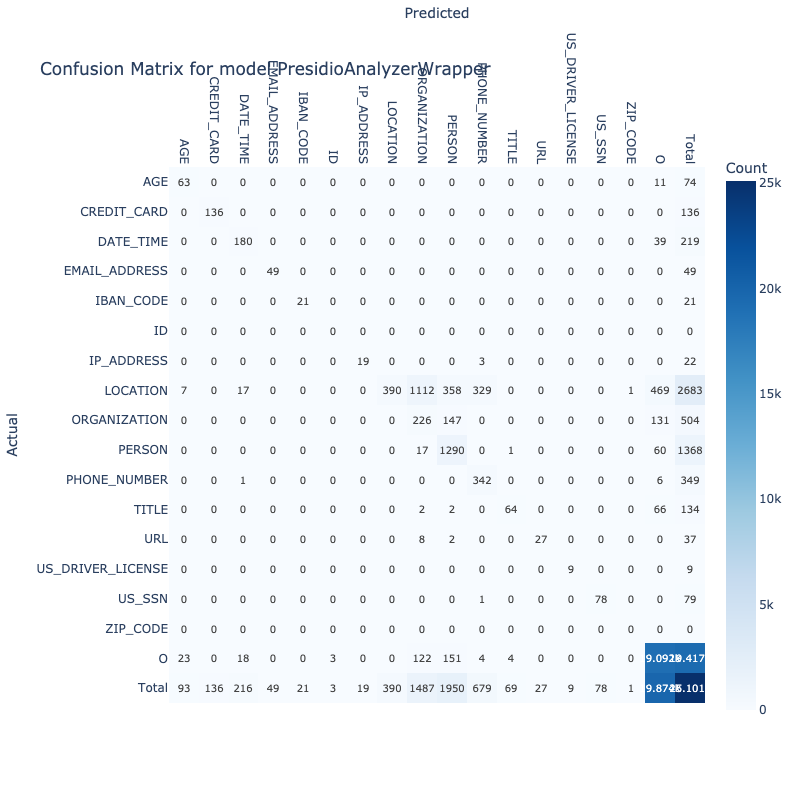

In [58]:
plotter.plot_confusion_matrix(entities=entities, confmatrix=confmatrix)
#plotter.plot_confusion_matrix(entities=entities, confmatrix=confmatrix, save_as="png")

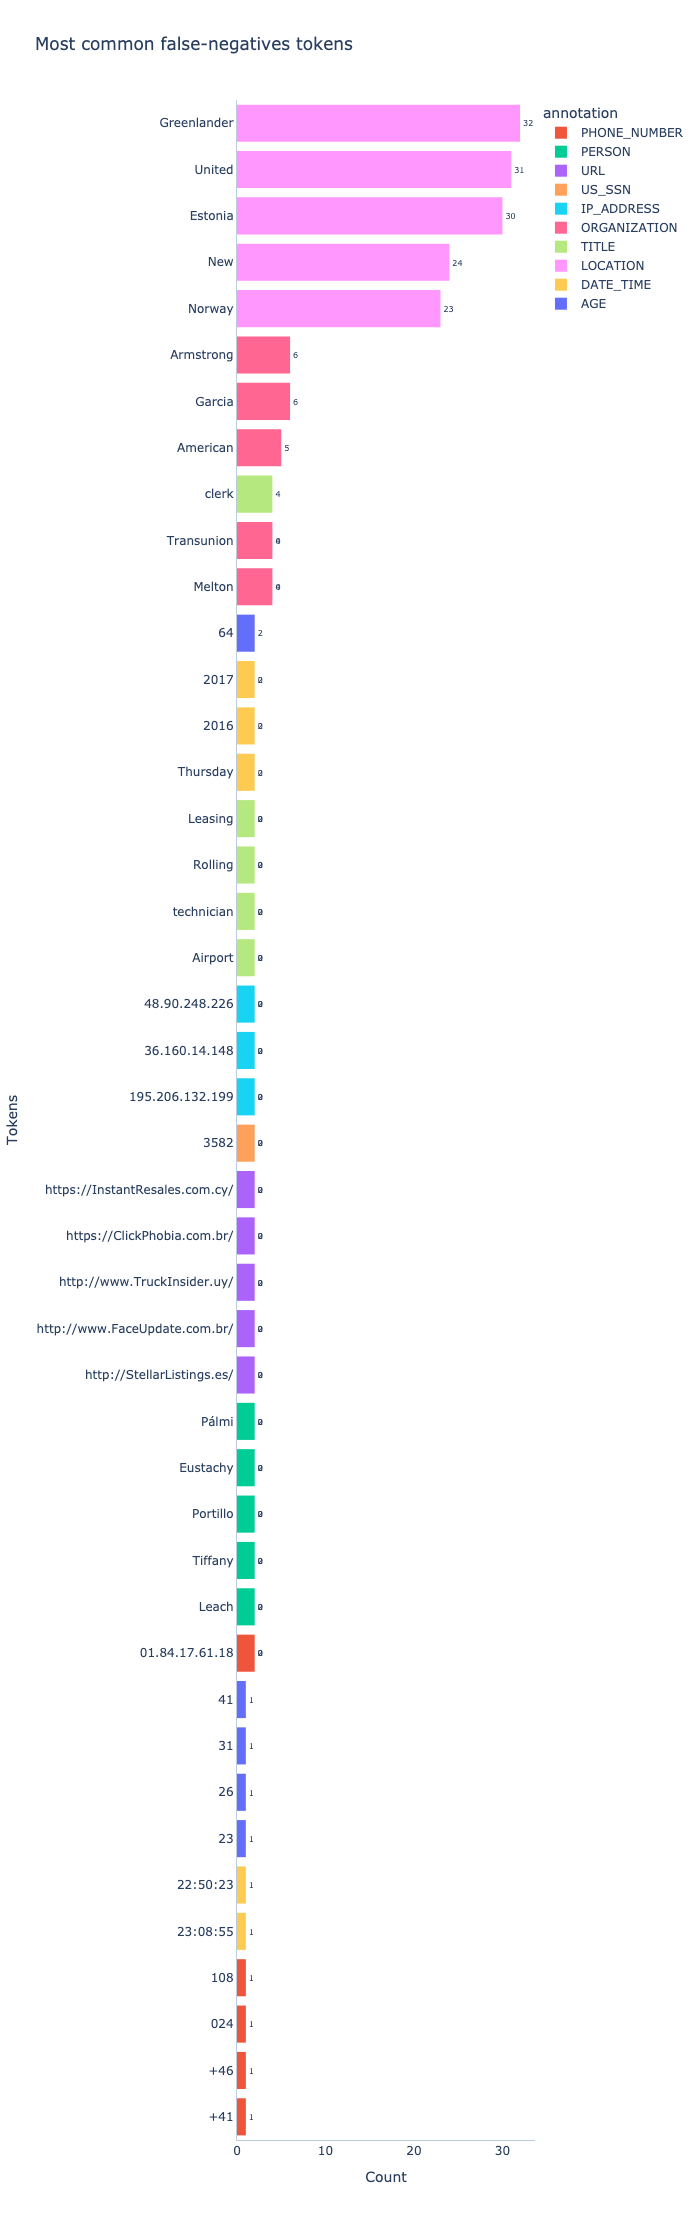

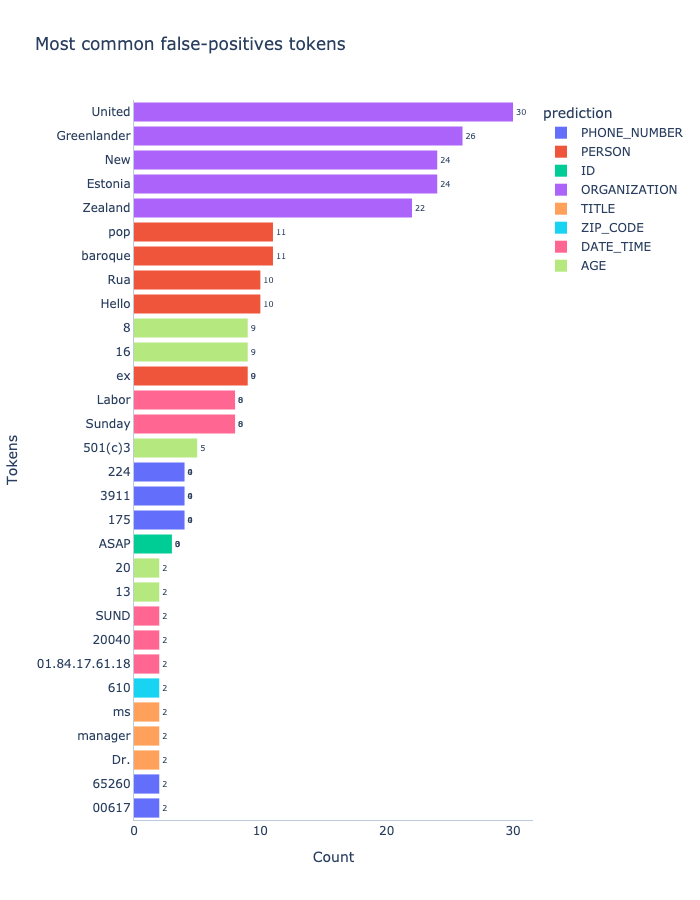

In [59]:
plotter.plot_most_common_tokens()

### 7a. False positives
#### Most common false positive tokens:

In [34]:
ModelError.most_common_fp_tokens(results.model_errors)

Most common false positive tokens:
[('Greenlander', 17),
 ('Estonia', 15),
 ('United', 15),
 ('card', 14),
 ('Southern', 12),
 ('IBAN', 12),
 ('New', 12),
 ('baroque', 11),
 ('pop', 11),
 ('Princess', 11)]
---------------
Example sentence with each FP token:
	- Marisa Bisliev

583 Magrethevej 298
 Apt. 123
 Qasigiannguit
 Greenlander 07609 (`Greenlander` pred as ORGANIZATION)
	- William Hughes

20789 Allika 46
 Suite 501
 Riisa

 Estonia 62488 (`Estonia` pred as ORGANIZATION)
	- card number 347415977307943 is lost, can you please send a new one to 14 Crown Street Kishiev Squares
 Suite 321
 LONDON
 United Kingdom 75419? I am in Sutri for a business trip (`United` pred as ORGANIZATION)
	- What is the limit for card 4454794511390933? (`card` pred as ORGANIZATION)
	- The Exversion Orchestra was founded in 1977. Since then, it has grown from a volunteer community orchestra to a fully professional orchestra serving Southern Tunisia (`Southern` pred as ORGANIZATION)
	- Hi Freddy, I'm contact

[('Greenlander', 17),
 ('Estonia', 15),
 ('United', 15),
 ('card', 14),
 ('Southern', 12),
 ('IBAN', 12),
 ('New', 12),
 ('baroque', 11),
 ('pop', 11),
 ('Princess', 11)]

#### More FP analysis

In [35]:
fps_df = ModelError.get_fps_dataframe(results.model_errors, entity=["AGE"])
fps_df[["full_text", "token", "annotation", "prediction"]].head(20)

,full_text,token,annotation,prediction
0,"Celebrating its 10th year in Tobel, Transunion is a 501(c)3 that invites songwriters from around the world to Port Paien to share the universal language of music in collaborations designed to bridge cultures, build friendships and cultivate peace.",501(c)3,O,AGE
1,Energetic and driven salesperson with 8+ years of professional experience in inbound and outbound sales. Awarded Salesperson of the Month three times. Helped increase inbound sales by 16% within the first year of employment. Looking to support Factset in Bjert 6091 in its mission to become a market-leading solution.,8,O,AGE
2,Energetic and driven salesperson with 8+ years of professional experience in inbound and outbound sales. Awarded Salesperson of the Month three times. Helped increase inbound sales by 16% within the first year of employment. Looking to support Factset in Bjert 6091 in its mission to become a market-leading solution.,16,O,AGE
3,Energetic and driven salesperson with 8+ years of professional experience in inbound and outbound sales. Awarded Salesperson of the Month three times. Helped increase inbound sales by 16% within the first year of employment. Looking to support MysticWeb in Quinta de São Tiago 3610-114 in its mission to become a market-leading solution.,8,O,AGE
4,Energetic and driven salesperson with 8+ years of professional experience in inbound and outbound sales. Awarded Salesperson of the Month three times. Helped increase inbound sales by 16% within the first year of employment. Looking to support MysticWeb in Quinta de São Tiago 3610-114 in its mission to become a market-leading solution.,16,O,AGE
5,Energetic and driven salesperson with 8+ years of professional experience in inbound and outbound sales. Awarded Salesperson of the Month three times. Helped increase inbound sales by 16% within the first year of employment. Looking to support Nautilytics in København K 1421 in its mission to become a market-leading solution.,8,O,AGE
6,Energetic and driven salesperson with 8+ years of professional experience in inbound and outbound sales. Awarded Salesperson of the Month three times. Helped increase inbound sales by 16% within the first year of employment. Looking to support Nautilytics in København K 1421 in its mission to become a market-leading solution.,16,O,AGE
7,"Celebrating its 10th year in Laax, Environmental Data Resources is a 501(c)3 that invites songwriters from around the world to Niitabury to share the universal language of music in collaborations designed to bridge cultures, build friendships and cultivate peace.",501(c)3,O,AGE
8,"Celebrating its 10th year in Kędzierzyn-Koźle, Transunion is a 501(c)3 that invites songwriters from around the world to Pudičmouth to share the universal language of music in collaborations designed to bridge cultures, build friendships and cultivate peace.",501(c)3,O,AGE
9,"Celebrating its 10th year in WINMALEE, Weeks-Rivas is a 501(c)3 that invites songwriters from around the world to Berggrenton to share the universal language of music in collaborations designed to bridge cultures, build friendships and cultivate peace.",501(c)3,O,AGE


### 7b. False negatives (FN)

#### Most common false negative examples + a few samples with FN

In [36]:
ModelError.most_common_fn_tokens(results.model_errors, n=15)

Most common false negative tokens:
[('Greenlander', 17),
 ('United', 16),
 ('Estonia', 15),
 ('Norway', 13),
 ('Czech', 12),
 ('New', 12),
 ('Austria', 11),
 ('Zealand', 11),
 ('Belgium', 11),
 ('Avenue', 10),
 ('Netherlands', 10),
 ('Republic', 10),
 ('Rua', 10),
 ('Sweden', 10),
 ('Road', 10)]
---------------
Example sentence with each FN token:
	- Marisa Bisliev

583 Magrethevej 298
 Apt. 123
 Qasigiannguit
 Greenlander 07609 (`Greenlander` annotated as LOCATION)
	- Blink-182 pay tribute here to the United States. Producer Christoffer Bertelsen explained to Fuse TV: "We all liked the idea of writing a song about our state, where we live and love. To me it's the most beautiful place in the world, this song was us giving credit to how lucky we are to have lived here and grown up here, raising families here, the whole thing." (`United` annotated as LOCATION)
	- William Hughes

20789 Allika 46
 Suite 501
 Riisa

 Estonia 62488 (`Estonia` annotated as LOCATION)
	- Blink-182 pay tribute h

[('Greenlander', 17),
 ('United', 16),
 ('Estonia', 15),
 ('Norway', 13),
 ('Czech', 12),
 ('New', 12),
 ('Austria', 11),
 ('Zealand', 11),
 ('Belgium', 11),
 ('Avenue', 10),
 ('Netherlands', 10),
 ('Republic', 10),
 ('Rua', 10),
 ('Sweden', 10),
 ('Road', 10)]

#### More FN analysis

In [54]:
fns_df = ModelError.get_fns_dataframe(results.model_errors, entity=["PERSON"])

In [55]:
fns_df[["full_text", "token", "annotation", "prediction"]].head(20)

,full_text,token,annotation,prediction
0,"Unlike the Christiansen novel, it's not about necrophilia. What it is about, I suppose is anyone's guess. A brilliant piece of baroque pop.",Christiansen,PERSON,O
1,"Ubul: What a wife.\nNicole: Remember me, Mary? When I killed your brother, I talked just like this!\nJohn: You saved my life! How can I ever repay you?",Mary,PERSON,O
2,"Unlike the Jensen novel, it's not about necrophilia. What it is about, I suppose is anyone's guess. A brilliant piece of baroque pop.",Jensen,PERSON,O
3,"C'mon, sing it with me: ""You picked a fine time to leave me Mette, four hungry children and a crop in the field...""",Mette,PERSON,O
4,Why is Katrine so impulsive?,Katrine,PERSON,O
5,Have you been to a Ravil G Yefimov concert before?,Ravil,PERSON,O
6,Have you been to a Ravil G Yefimov concert before?,G,PERSON,O
7,Have you been to a Ravil G Yefimov concert before?,Yefimov,PERSON,O
8,"Kevin had given Alma his address: 5049 Harjukuja 54, SEINÄJOKI",Alma,PERSON,O
9,"Leif, can I please speak to your boss?",Leif,PERSON,O
